dl buf: [-15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2
   3   4   5   6   7   8   9  10  11  12  13  14  15]
ds buf: [-15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2
   3   4   5   6   7   8   9  10  11  12  13  14  15]


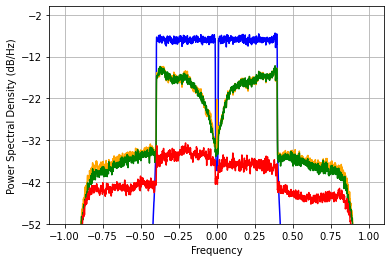

Accuracy =  -27.592802679542856 dbs


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

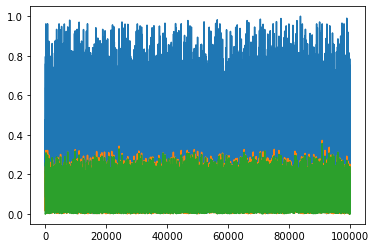

In [72]:
import matplotlib.pyplot as plt
import numpy as np



def NMSE(x, y):
    return 10*np.log10(np.abs(np.matmul(np.conj(x.T), x)/np.matmul(np.conj(y.T), y)))



def mu_opt_calc(gamma, R):
    gamma = gamma.reshape(gamma.shape[0], 1)
    gammaH = np.conj(gamma).reshape(1, gamma.shape[0])
    mu_opt = np.dot(gammaH, gamma) / np.dot(np.dot(gammaH, R), gamma)
    return mu_opt[0, 0]


x = np.load('data/lte_2c_data1_in.npy')
y = np.load('data/lte_2c_data1_out.npy')


coeff = max(abs(x[0:100000]))

x = x[0:100000] / coeff
y = y[0:100000] / coeff


d = y - x

ORD = 9
buffer_size = 31

steps = 100

dl = np.zeros(buffer_size, dtype = int)
ds = np.zeros(buffer_size, dtype = int)

dl_elem = -15
ds_elem = -15

"dl = [-10, -9, -8, ......, 7, 8, 9, 10]"

for i in range(buffer_size):
    dl[i] = dl_elem
    dl_elem = dl_elem + 1
    
print("dl buf:", dl)

i = 0

for i in range(buffer_size):
    ds[i] = ds_elem 
    ds_elem = ds_elem + 1
   
print("ds buf:", ds)

mem = buffer_size

U = np.zeros((len(d), mem*(ORD+1)), dtype = complex)


ind = np.arange(20,len(d)-20)
for k in ind:
    for m in range(mem):
        for p in range(ORD+1):
            U[k, p+m*(ORD+1)] = x[k - dl[m]] * abs(x[k - ds[m]])**(2*p)
        
            
##LS estimation
     
Rxx = np.matmul(np.conj(U.T), U)
rdy = np.matmul(np.conj(U.T), d)

w = np.matmul(np.linalg.pinv(Rxx),rdy)



"""
## LMS estimation ##
w = np.zeros(mem*(ORD+1), dtype=complex)

for i in range(steps):
    gamma = p - np.matmul(Rxx,w)
    mu_opt = mu_opt_calc(gamma, Rxx)
    w = w - mu_opt*(np.matmul(Rxx, w) - rdy)
"""



z = np.matmul(U, w)


plt.figure(1)

plt.ylim(-52, 0)

#input signal
plt.psd(x, NFFT = 2048, color = "blue")

#desired signal 
plt.psd(d, NFFT = 2048, color = "orange")

#output signal
plt.psd(z, NFFT = 2048, color = "green")

#error of the signal
#we should minimaze this signal
plt.psd(d-z - np.mean(d-z) , NFFT = 2048, color = "red")

plt.grid(True)
plt.show()


##accuracy = NMSE(x, z-d - np.mean(z-d))
accuracy = NMSE(d-z - np.mean(d-z), x)

print('Accuracy = ',  accuracy, 'dbs')
        

plt.figure(2)
plt.plot(abs(x))
plt.plot(abs(d))
plt.plot(abs(z))
plt.plot